In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import cPickle as pickle
import nolearn
import nolearn.lasagne
import lasagne.layers
from ml_helpers import minibatch_generators as mbg
import numpy as np
base = '/media/michael/Seagate/engage/urban8k/'

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5004)
/home/michael/anaconda/lib/python2.7/site-packages/Theano-0.9.0.dev1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
# loading data
folds = {}
for fold in range(1, 11):
    loadpath = base + 'specs_no_log/fold%d.pkl' % fold
    folds[fold] = pickle.load(open(loadpath))

In [43]:
def mean_normalise(X):
    med = np.mean(X.reshape(X.shape[0], -1), 1)
    med[med==0] = 0.0001
    return X / med[:, None, None, None]

def med_subtract(X):
    med = np.median(X, 3)
    return X - med[:, :, None, :]
    

splits = {'train': [1, 2, 3, 4, 5, 6, 7, 8, 10], 'val': [9], 'test': [10]}

data = {'train': {'X': [], 'y': []}, 
        'val': {'X': [], 'y': []}, 
        'test': {'X': [], 'y': []}}

for key, val in splits.iteritems():
    for fold_id in val:
        data[key]['X'] += folds[fold_id]['X']
        data[key]['y'] += list(folds[fold_id]['classID'])

    data[key]['X'] = mbg.form_correct_shape_array(data[key]['X'])
    data[key]['y'] = np.array(data[key]['y']).astype(np.int32)
    
# #     # now do different combinations of channels normalised differently
#     mean_norm = mean_normalise(data[key]['X']).astype(np.float32)
#     med_subt = med_subtract(data[key]['X']).astype(np.float32)
#     med_subt = med_subt - med_subt.min()
#     original = data[key]['X'] - data[key]['X'].min()
#     data[key]['X'] = np.concatenate( (mean_norm, med_subt, original), 1)
#     data[key]['X'] = data[key]['X'].astype(np.float32)

In [49]:
# mapper = {0:0, 7:1, 4:2}
# for fold in data:
#     y = data[fold]['y']
#     idxs = np.logical_or.reduce((y==0, y==4, y==7))
#     data[fold]['X'] = data[fold]['X'][idxs]
#     data[fold]['y'] = np.array([mapper[y] for y in data[fold]['y'][idxs]]).astype(np.int32)
# print data[fold]['y']
print data['train']['X'].dtype
print data['train']['X'].mean()
print data['train']['X'].min()
print data['train']['X'].astype(np.float32).max()
np.float32.
# for key in data:
#     print np.isnan(data[key]['X']).sum(),
#     print data[key]['X'].min(), data[key]['X'].max()

float32
3.25005e+12
0.0
2.73789e+16


4294967296

In [27]:
import librosa
mel_filts = librosa.filters.mel(44000, n_fft=2*224, n_mels=128).astype(np.float32)
print mel_filts.shape

(128, 225)


In [28]:
import theano.tensor as T

class Log1Plus(lasagne.layers.Layer):
    def __init__(self, incoming, off=lasagne.init.Constant(1.0), mult=lasagne.init.Constant(1.0), **kwargs):
        super(Log1Plus, self).__init__(incoming, **kwargs)
        num_channels = self.input_shape[1]
        self.off = self.add_param(off, shape=(num_channels,), name='off')
        self.mult = self.add_param(mult, shape=(num_channels,), name='mult')
        
    def get_output_for(self, input, **kwargs):
        return T.log(self.off.dimshuffle('x', 0, 'x', 'x') + self.mult.dimshuffle('x', 0, 'x', 'x') * input)
    
    def get_output_shape_for(self, input_shape):
        return input_shape

In [32]:
from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
import librosa
import theano
mel_filts = librosa.filters.mel(44000, n_fft=2*224, n_mels=128).astype(np.float32)[:, :-1]
mel_init = theano.shared(mel_filts[:, None, None, :])

net = {}

net['input'] = InputLayer((None, 3, 224, 224))
net['input2'] = PoolLayer(net['input'], 2, mode='average_inc_pad')
net['input_logged'] = Log1Plus(net['input2'])


# fake mel
#net['conv1_0'] = ConvLayer(
#    net['input_logged'], 128, (1, 224), nonlinearity=None, b=None, W=mel_init)
#net['conv1_0_dimshuffled'] = DimshuffleLayer(net['conv1_0'], (0, 3, 1, 2))

# full-height filter
# net['conv1_1'] = ConvLayer(net['conv1_0_dimshuffled'], 128, (128, 3), nonlinearity=vlr)
# net['conv1_1_dimshuffled'] = DimshuffleLayer(net['conv1_1'], (0, 2, 1, 3))

#net['conv1_1'] = ConvLayer(net['conv1_0_dimshuffled'], 32, 3, nonlinearity=vlr)

net['conv1_1'] = ConvLayer(net['input_logged'], 32, 3, nonlinearity=vlr)
# net['pool0'] = PoolLayer(net['conv1_0'], 2, mode='average_inc_pad')
net['conv1_2'] = ConvLayer(net['conv1_1'], 32, 3, nonlinearity=vlr)
net['pool1'] = PoolLayer(net['conv1_2'], 4)

net['conv2_1'] = ConvLayer(net['pool1'], 32, 3, nonlinearity=vlr)
net['conv2_2'] = ConvLayer(net['conv2_1'], 32, 3, nonlinearity=vlr)
net['pool2'] = PoolLayer(net['conv2_2'], 4)

# net['conv3_1'] = ConvLayer(net['pool2'], 32, 3, pad=1, flip_filters=False)
# net['conv3_2'] = ConvLayer(net['conv3_1'], 32, 3, pad=1, flip_filters=False)
net['fc6'] = DenseLayer(net['pool2'], num_units=256, nonlinearity=vlr)
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6'], num_units=256, nonlinearity=vlr)
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=10, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

In [33]:
# setting up network
class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        return data['train']['X'], data['val']['X'], data['train']['y'], data['val']['y']

def augment(X):
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.01
        X[idx] *= mult
        X[idx] += add
        if np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            X[idx, 0] = np.roll(X[idx, 0], shift, 1)
        
    return X
    
class MyBatch(nolearn.lasagne.BatchIterator):
    def transform(self, Xb, yb):
        return augment(Xb), yb

    def __iter__(self):
        bs = self.batch_size
        for batch_idxs in mbg.minibatch_idx_iterator(
                self.y, bs, randomise=1, balanced=1):

            Xb = self.X[batch_idxs]
            yb = self.y[batch_idxs]
            yield self.transform(Xb, yb)
    

network = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=500,
    update=lasagne.updates.adam,
    update_learning_rate=0.0005,
    verbose=1,
    train_split=MyTrainSplit(None),
    batch_iterator_train=MyBatch(batch_size=64)
)

network.initialize()

In [34]:
# training
# network.load_params_from('mel_fake_full_71%.pkl'),

network.fit(data, None)

# Neural Network with 302064 learnable parameters

## Layer information

  #    name  size
---  ------  ----------
  0          3x224x224
  1          3x112x112
  2          3x112x112
  3          32x110x110
  4          32x108x108
  5          32x27x27
  6          32x25x25
  7          32x23x23
  8          32x5x5
  9          256
 10          256
 11          256
 12          256
 13          10
 14          10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.06157       1.58977      1.29677      0.45201  42.92s
      2       1.41661       1.31019      1.08123      0.53460  43.10s
      3       1.17227       1.15628      1.01382      0.61086  43.64s
      4       1.00853       1.14189      0.88321      0.63318  42.78s
      5       0.89247       1.07411      0.83089      0.64955  42.89s
      6       0.81186       1.08122      0.75088      0.63467  42.90s
      7       0.73330   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fd9c9c8b3d0>,
     batch_iterator_train=<__main__.MyBatch object at 0x7fd988d080d0>,
     check_input=True, custom_epoch_scores=None, custom_scores=None,
     layers=[<lasagne.layers.special.NonlinearityLayer object at 0x7fd988d12810>],
     loss=None, max_epochs=500, more_params={},
     objective=<function objective at 0x7fd9c9c8d9b0>,
     objective_loss_function=<function categorical_crossentropy at 0x7fd9caa307d0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7fd988e6f680>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7fd988e6f050>],
     regression=False,
     train_split=<__main__.MyTrainSplit object at 0x7fd988d69bd0>,
     update=<function adam at 0x7fd9ca9c7578>, update_learning_rate=0.0005,
     use_label_encoder=False, verbose=1,
     y_tensor_type=Ten

In [37]:
a = lasagne.layers.get_all_params(network.layers)[0]
print a.get_value()
a = lasagne.layers.get_all_params(network.layers)[1]
print a.get_value()

[ 0.87472224]
[ 1.3921808]


In [35]:
# network.save_params_to('75%_acc_5463427b.pkl')
# network.save_params_to('mel_fake_70%.pkl')

from sklearn.metrics import confusion_matrix
from ml_helpers.evaluation import plot_confusion_matrix

tmp = pickle.load(open(loadpath))
mapper = dict(zip(tmp['classID'], tmp['class']))
print mapper
cls_labels = [mapper[xx] for xx in range(10)]#[0, 4, 7]]
print cls_labels

y_pred = network.predict(data['val']['X'])

{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


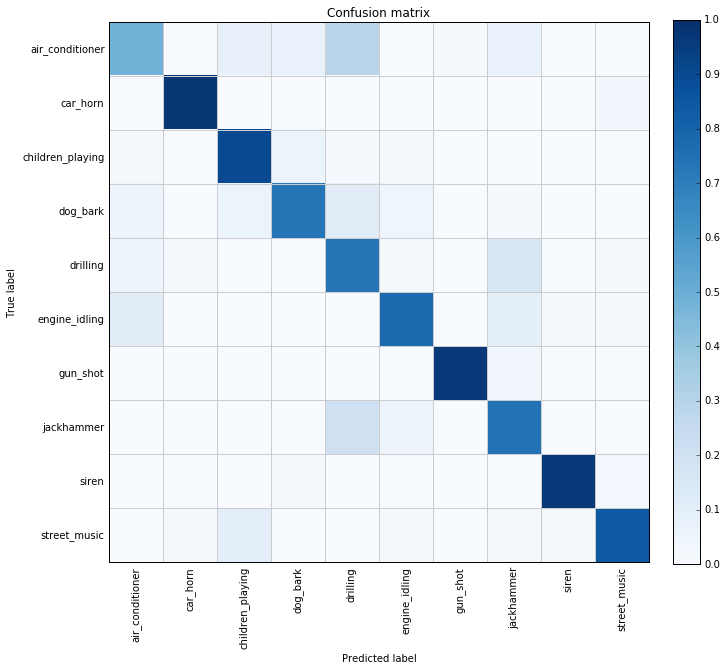

In [36]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(data['val']['y'], y_pred, normalise=1,
        cls_labels=cls_labels)

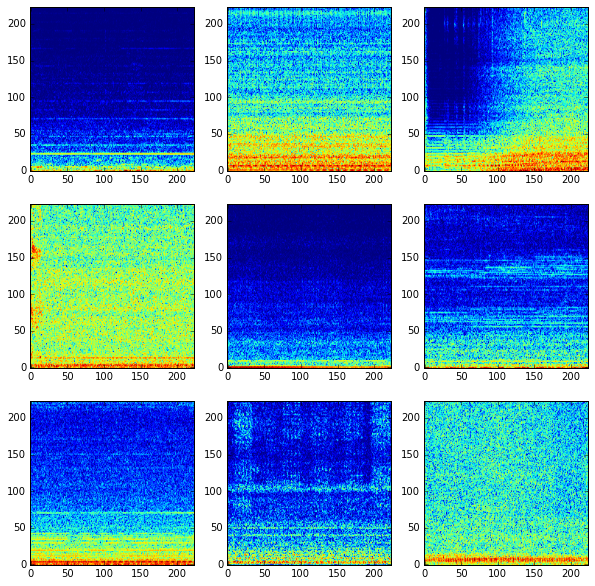

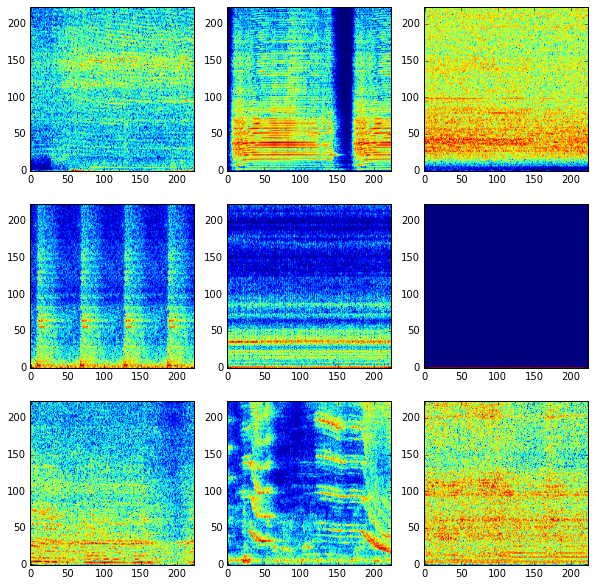

In [82]:
scale = 0
# network.save_params_to('mel_fake_full_71%.pkl')
plt.figure(figsize=(10, 10))
idxs = np.where(data['train']['y'] == 0)[0]
import random
random.shuffle(idxs)
for idx, xx in enumerate(data['train']['X'][idxs][:9]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(xx[0])
    plt.gca().invert_yaxis()
    if scale: plt.clim(0, 3)
    
# network.save_params_to('mel_fake_full_71%.pkl')
plt.figure(figsize=(10, 10))
idxs = np.where(data['train']['y'] == 2)[0]
random.shuffle(idxs)
for idx, xx in enumerate(data['train']['X'][idxs][:9]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(xx[0])
    plt.gca().invert_yaxis()
    if scale: plt.clim(0, 3)

In [91]:
preds = network.predict_proba(data['val']['X'])

In [111]:
baddest = np.where(np.logical_and(data['val']['y'] == 0, preds[:, 1] > 0.9))[0]
print baddest

[  0   2   3  16  23 217 218 219 221 222 224 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267]


In [131]:
import pandas as pd
base = '/media/michael/Seagate/engage/urban8k/UrbanSound8K/audio/'
metadata = pd.read_csv(base + '../metadata/UrbanSound8K.csv')
tmp = metadata[metadata.fold==9]
to_use = tmp[tmp['classID'] == 0]
to_use = tmp.iloc[0]['slice_file_name']
print tmp.iloc[0]['class']

air_conditioner


In [127]:
import IPython
path = base + 'fold%d/%s' % (9, to_use)
IPython.display.Audio(path)

In [29]:
# network.save_params_to('plus_one_first_go.pkl')